Verify Installation

In [6]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import BertTokenizer, BertModel


Test Transformers & BERT:

In [7]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

print("BERT model loaded successfully")


BERT model loaded successfully


Reload + Preprocess Before BERT

Load dataset

In [8]:
import pandas as pd

# Load your dataset
df = pd.read_csv("messages.csv")

# Combine subject + message
df["text"] = df["subject"].fillna("") + " " + df["message"]


Preprocess

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources (only first time)
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # keep only letters
    tokens = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
    return " ".join(tokens)

df["clean_text"] = df["text"].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adith\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


We’ll now convert your clean_text into BERT embeddings using HuggingFace.

Load Berth

In [10]:
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm  # progress bar

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model = bert_model.to("cuda")  # use GPU
print("BERT model loaded successfully")


BERT model loaded successfully


Convert to BERT Embeddings

In [11]:
import numpy as np  # <-- Add this

def get_bert_embeddings(texts, tokenizer, model, max_len=128):
    embeddings = []
    model.eval()

    for text in tqdm(texts, desc="Embedding"):
        inputs = tokenizer(
            text, return_tensors="pt", padding="max_length",
            truncation=True, max_length=max_len
        )
        inputs = {k: v.to("cuda") for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_state = outputs.last_hidden_state
            mean_emb = last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        embeddings.append(mean_emb)

    return np.array(embeddings)

# Generate embeddings + labels
X = get_bert_embeddings(df["clean_text"].tolist(), tokenizer, bert_model)
y = df["label"].values

print("Embeddings shape:", X.shape)


Embedding:   0%|          | 0/2893 [00:00<?, ?it/s]

Embedding: 100%|██████████| 2893/2893 [03:39<00:00, 13.17it/s]

Embeddings shape: (2893, 768)


In [12]:
from sklearn.model_selection import train_test_split

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (2314, 768) (2314,)
Test shape: (579, 768) (579,)


Train/Test Split

In [13]:
import numpy as np

# Reshape embeddings for LSTM
X_train_lstm = np.expand_dims(X_train, axis=2)  # (samples, 768, 1)
X_test_lstm  = np.expand_dims(X_test, axis=2)

print("LSTM input shape:", X_train_lstm.shape, X_test_lstm.shape)


LSTM input shape: (2314, 768, 1) (579, 768, 1)


Build BiLSTM Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=False), input_shape=(768, 1)))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer=Adam(1e-3), metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              133120    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 133,377
Trainable params: 133,377
Non-trainable params: 0
_________________________________________________________________


Train Model

In [15]:
history = model.fit(
    X_train_lstm, y_train,
    validation_data=(X_test_lstm, y_test),
    epochs=5,  # start with 5 (can increase to 10–20 for better results)
    batch_size=32
)


Epoch 1/5
73/73 [==============================] - 29s 306ms/step - loss: 0.4831 - accuracy: 0.8332 - val_loss: 0.4460 - val_accuracy: 0.8342
Epoch 2/5
73/73 [==============================] - 13s 179ms/step - loss: 0.4418 - accuracy: 0.8336 - val_loss: 0.4349 - val_accuracy: 0.8342
Epoch 3/5
73/73 [==============================] - 22s 304ms/step - loss: 0.4250 - accuracy: 0.8336 - val_loss: 0.3942 - val_accuracy: 0.8342
Epoch 4/5
73/73 [==============================] - 25s 345ms/step - loss: 0.4008 - accuracy: 0.8366 - val_loss: 0.3983 - val_accuracy: 0.8342
Epoch 5/5
73/73 [==============================] - 21s 284ms/step - loss: 0.3681 - accuracy: 0.8332 - val_loss: 0.3396 - val_accuracy: 0.8359


Evaluate

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = (model.predict(X_test_lstm) > 0.5).astype("int32")

# Classification report
print(classification_report(y_test, y_pred, target_names=["Ham", "Spam"]))


19/19 [==============================] - 3s 70ms/step
              precision    recall  f1-score   support

         Ham       0.84      1.00      0.91       483
        Spam       1.00      0.01      0.02        96

    accuracy                           0.84       579
   macro avg       0.92      0.51      0.47       579
weighted avg       0.86      0.84      0.76       579



Classification Metrics
Confusion Matrix Heatmap

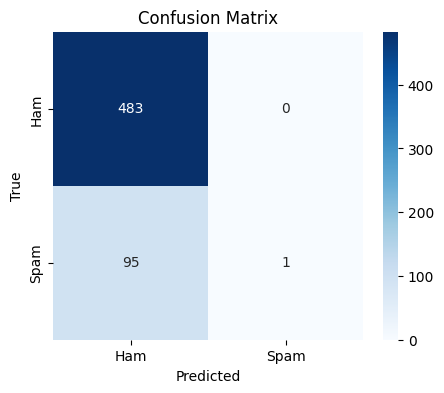

In [17]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Ham", "Spam"],
            yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Training Curves (Accuracy & Loss)

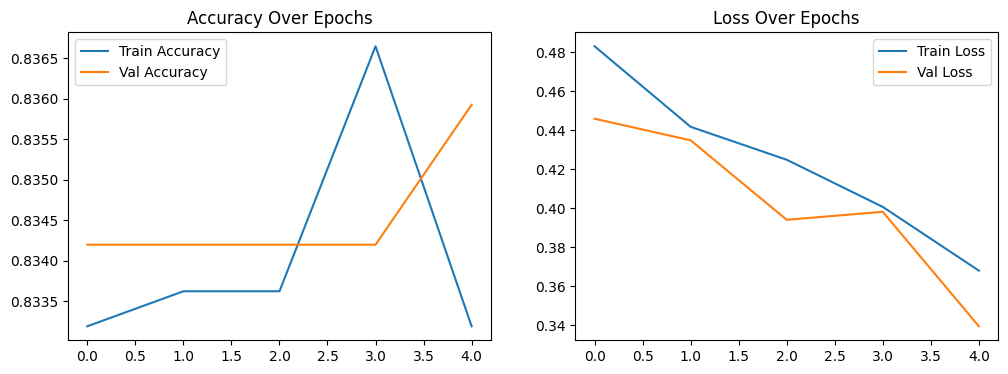

In [18]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")

plt.show()


Import GWO

In [19]:
from mealpy.swarm_based import GWO
from sklearn.metrics import f1_score
import numpy as np


Define Fitness Function

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def fitness_function(solution):
    # solution = binary mask (0/1) of selected features
    mask = solution > 0.5  # threshold
    if mask.sum() == 0:  # avoid empty feature set
        return 1.0
    
    # Select features
    X_selected = X[:, mask]
    
    # Simple classifier for fitness evaluation
    clf = LogisticRegression(max_iter=200)
    score = cross_val_score(clf, X_selected, y, cv=3, scoring="f1").mean()
    
    return 1 - score  # GWO minimizes, so invert


In [21]:
from mealpy.swarm_based import GWO
from mealpy.utils.space import FloatVar
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# =========================
# 1) Fitness Function (F1 + Accuracy)
# =========================
def fitness_function(solution):
    mask = (np.array(solution) > 0.5).astype(int)
    if mask.sum() == 0:
        return 1.0  # penalty if no features selected

    X_selected = X[:, mask == 1]
    X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
        X_selected, y, test_size=0.2, random_state=42, stratify=y
    )

    clf = LogisticRegression(max_iter=500)
    clf.fit(X_train_sel, y_train_sel)
    y_pred = clf.predict(X_test_sel)

    f1 = f1_score(y_test_sel, y_pred)
    acc = accuracy_score(y_test_sel, y_pred)

    weighted = 0.7*f1 + 0.3*acc
    return 1 - weighted   # minimize (1 - score)

# =========================
# 2) Define bounds
# =========================
bounds = FloatVar(
    lb=(0,) * X.shape[1],
    ub=(1,) * X.shape[1],
    name="features"
)

problem = {
    "obj_func": fitness_function,
    "bounds": bounds,
    "minmax": "min",
}

# =========================
# 3) Run GWO with stronger search
# =========================
model = GWO.CG_GWO(epoch=100, pop_size=50)  # 🚀 bigger search
best_agent = model.solve(problem)

# Convert solution → binary mask
best_position = (np.array(best_agent.solution) > 0.5).astype(int)
best_fitness = best_agent.target.fitness

print("Best fitness (1 - score):", best_fitness)
print("Selected features:", best_position.sum())

# =========================
# 4) Apply feature mask
# =========================
X_selected = X[:, best_position == 1]
print("Original features:", X.shape[1])
print("Final selected features:", X_selected.shape[1])

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# Reshape for LSTM
X_train_lstm = np.expand_dims(X_train, axis=2)
X_test_lstm  = np.expand_dims(X_test, axis=2)
print("LSTM input shape:", X_train_lstm.shape, X_test_lstm.shape)

# =========================
# 5) BiLSTM Model
# =========================
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

lstm_model.compile(loss="binary_crossentropy", optimizer=Adam(1e-3), metrics=["accuracy"])

# Early stopping
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train
history = lstm_model.fit(
    X_train_lstm, y_train,
    validation_data=(X_test_lstm, y_test),
    epochs=30,              # longer training
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# =========================
# 6) Evaluate
# =========================
loss, acc = lstm_model.evaluate(X_test_lstm, y_test)
print(f"\n🔥 Test Accuracy after enhanced GWO + BiLSTM: {acc:.4f}")


2025/09/05 05:01:08 PM, INFO, mealpy.swarm_based.GWO.CG_GWO: CG_GWO(epoch=100, pop_size=50)
2025/09/05 05:01:22 PM, INFO, mealpy.swarm_based.GWO.CG_GWO: >>>Problem: P, Epoch: 1, Current best: 0.008327936096718447, Global best: 0.008327936096718447, Runtime: 8.17516 seconds
2025/09/05 05:01:30 PM, INFO, mealpy.swarm_based.GWO.CG_GWO: >>>Problem: P, Epoch: 2, Current best: 0.008327936096718447, Global best: 0.008327936096718447, Runtime: 8.53570 seconds
2025/09/05 05:01:41 PM, INFO, mealpy.swarm_based.GWO.CG_GWO: >>>Problem: P, Epoch: 3, Current best: 0.008327936096718447, Global best: 0.008327936096718447, Runtime: 10.63245 seconds
2025/09/05 05:01:49 PM, INFO, mealpy.swarm_based.GWO.CG_GWO: >>>Problem: P, Epoch: 4, Current best: 0.008327936096718447, Global best: 0.008327936096718447, Runtime: 8.10135 seconds
2025/09/05 05:01:57 PM, INFO, mealpy.swarm_based.GWO.CG_GWO: >>>Problem: P, Epoch: 5, Current best: 0.008327936096718447, Global best: 0.008327936096718447, Runtime: 8.28899 secon

Best fitness (1 - score): 0.0
Selected features: 173
Original features: 768
Final selected features: 173
LSTM input shape: (2314, 173, 1) (579, 173, 1)
Epoch 1/30
73/73 [==============================] - 10s 66ms/step - loss: 0.4831 - accuracy: 0.8271 - val_loss: 0.4654 - val_accuracy: 0.8342
Epoch 2/30
73/73 [==============================] - 4s 48ms/step - loss: 0.4576 - accuracy: 0.8332 - val_loss: 0.4536 - val_accuracy: 0.8342
Epoch 3/30
73/73 [==============================] - 4s 52ms/step - loss: 0.4551 - accuracy: 0.8336 - val_loss: 0.4491 - val_accuracy: 0.8342
Epoch 4/30
73/73 [==============================] - 5s 69ms/step - loss: 0.4564 - accuracy: 0.8336 - val_loss: 0.4495 - val_accuracy: 0.8342
Epoch 5/30
73/73 [==============================] - 5s 75ms/step - loss: 0.4531 - accuracy: 0.8336 - val_loss: 0.4487 - val_accuracy: 0.8342
Epoch 6/30
73/73 [==============================] - 6s 76ms/step - loss: 0.4478 - accuracy: 0.8336 - val_loss: 0.4140 - val_accuracy: 0.8377
E

Save Models

In [22]:
# Save BiLSTM model
lstm_model.save("spam_bilstm2.h5")

# Save GWO feature mask
np.save("gwo_features.npy", best_position)


In [ ]:
if __name__ == "__main__":
    import tkinter as tk
    from tkinter import messagebox
    from tensorflow.keras.models import load_model
    from transformers import BertTokenizer, BertModel
    import numpy as np
    import torch

    # Load model + features
    lstm_model = load_model("spam_bilstm2.h5")
    feature_mask = np.load("gwo_features.npy")
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    bert_model = BertModel.from_pretrained("bert-base-uncased")

    def get_embedding(text, tokenizer, model, max_len=128):
        inputs = tokenizer(text, return_tensors="pt", padding="max_length",
                           truncation=True, max_length=max_len)
        with torch.no_grad():
            outputs = model(**inputs)
            mean_emb = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        return mean_emb

    def predict_spam():
        email_text = text_box.get("1.0", tk.END).strip()
        if not email_text:
            messagebox.showwarning("Input Error", "Please enter an email text.")
            return
        emb = get_embedding(email_text, tokenizer, bert_model)
        emb_selected = emb[feature_mask == 1]
        X_input = np.expand_dims(emb_selected, axis=(0,2))
        pred = lstm_model.predict(X_input)[0][0]
        label = "🚨 Spam" if pred > 0.5 else "✅ Not Spam"
        confidence = pred*100 if pred > 0.5 else (1-pred)*100
        messagebox.showinfo("Prediction", f"Result: {label}\nConfidence: {confidence:.2f}%")

    # Tkinter UI
    root = tk.Tk()
    root.title("Spam Detector (BERT + GWO + BiLSTM")
    tk.Label(root, text="Enter email text:", font=("Arial", 12)).pack(pady=25)
    text_box = tk.Text(root, height=12, width=60)
    text_box.pack(padx=10, pady=5)
    predict_btn = tk.Button(root, text="Predict", font=("Arial", 12), command=predict_spam)
    predict_btn.pack(pady=10)
    root.mainloop()


c:\Users\Lenovo\.conda\envs\spam_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
